# Machine Predictive Maintenance

The purpose of this project is to predict maintenance needs for machinery in a manufacturing setting to forecast machinery failures. By predicting failures in advance, manufacturers can schedule maintenance proactively, minimizing downtime, reducing maintenance costs, and improving overall efficiency. 

#### **Data**

The dataset used in this project includes historical sensor data for machinery, with features that capture key machine parameters over time. The data contains 10,000 records, and the key features are:

- Air Temperature [K]: Air temperature in Kelvin.
- Process Temperature [K]: Process temperature in Kelvin.
- Rotational Speed [rpm]: Rotational speed of the machinery.
- Torque [Nm]: Torque applied in Newton-meters.
- Tool Wear [min]: Tool wear time in minutes.
- Machine Type: Categorical variable (L, M, H).
- Product Quality: Quality rating (1 = Low, 2 = Medium, 3 = High).
- Product Serial: Unique identifier for the product.

Targets:

- Target: Binary variable indicating failure (1 = Failure, 0 = No Failure).
- Failure Type: Categorical variable indicating failure type (e.g., "Heat Dissipation Failure", "Tool Wear Failure").

### 1. Import Libraries

In [1]:
import pandas as pd
import zipfile
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

### 2. Load Data

In [2]:
# 1. Extract and Load the Dataset
zip_file = 'predictive_maintenance.zip'
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall()

file_path = 'predictive_maintenance.csv'
data = pd.read_csv(file_path)

### 3. Inspect the Data

In [3]:
# Inspection: Initial Dataset
print("\nInitial Dataset Overview:")
print(data.head())
print("\nDataset Information:")
print(data.info())
print("\nMissing Values Summary:")
print(data.isnull().sum())


Initial Dataset Overview:
   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Target Failure Type  
0                    1551         42.8                0       0   No Failure  
1                    1408         46.3                3       0   No Failure  
2                    1498         49.4                5       0   No Failure  
3                    1433         39.5                7       0   No Failure  
4                    1408         40.0                9       0   No Failure  

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeI

In [4]:
data.describe()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


#### Key Findings

- **Temperature**: Air and process temperatures are stable and within narrow ranges, which suggests that environmental conditions are controlled.
- **Rotational Speed and Torque**: These have higher variation, and extreme values might indicate operational stress that could correlate with machinery failure.
- **Tool Wear**: A significant spread indicates that some machines are at risk of failure while others are still running well.
- **Target (Failure Indicator)**: The low mean and high standard deviation suggest a binary classification problem where most machines do not fail (0), but a small number do (1). This imbalance should be addressed when modeling.

### 4. Data Cleaning

In [5]:
# Drop irrelevant columns
data_cleaned = data.drop(columns=['UDI', 'Product ID'])
print("\nDataset After Dropping Irrelevant Columns:")
print(data_cleaned.head())

# Encode 'Type' using one-hot encoding
data_cleaned = pd.get_dummies(data_cleaned, columns=['Type'], prefix='Type')
print("\nDataset After One-Hot Encoding 'Type':")
print(data_cleaned.head())

# Encode 'Failure Type' using LabelEncoder
le = LabelEncoder()
data_cleaned['Failure Type Encoded'] = le.fit_transform(data_cleaned['Failure Type'])
print("\nEncoded 'Failure Type':")
for i, label in enumerate(le.classes_):
    print(f"{i}: {label}")

# Normalize continuous features
scaler = StandardScaler()
continuous_features = [
    'Air temperature [K]', 'Process temperature [K]',
    'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]'
]
data_cleaned[continuous_features] = scaler.fit_transform(data_cleaned[continuous_features])
print("\nDataset After Scaling Continuous Features:")
print(data_cleaned[continuous_features].head())

# Final Inspection of Cleaned Data
print("\nCleaned Dataset Overview:")
print(data_cleaned.head())
print("\nData Types After Cleaning:")
print(data_cleaned.dtypes)


Dataset After Dropping Irrelevant Columns:
  Type  Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
0    M                298.1                    308.6                    1551   
1    L                298.2                    308.7                    1408   
2    L                298.1                    308.5                    1498   
3    L                298.2                    308.6                    1433   
4    L                298.2                    308.7                    1408   

   Torque [Nm]  Tool wear [min]  Target Failure Type  
0         42.8                0       0   No Failure  
1         46.3                3       0   No Failure  
2         49.4                5       0   No Failure  
3         39.5                7       0   No Failure  
4         40.0                9       0   No Failure  

Dataset After One-Hot Encoding 'Type':
   Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
0                298.1        

### 4. Prepare Data for Training

In [6]:
# Separate features and targets
X = data_cleaned.drop(columns=['Target', 'Failure Type', 'Failure Type Encoded'])  # Features
y_binary = data_cleaned['Target']  # Binary target (Failure or Not)
y_multiclass = data_cleaned['Failure Type Encoded']  # Multi-class target (Failure Type)

# Ensure all features in X are numeric
X = X.apply(pd.to_numeric)

# Split data for binary classification
X_train, X_test, y_train_binary, y_test_binary = train_test_split(
    X, y_binary, test_size=0.2, stratify=y_binary, random_state=42
)

# Split data for multi-class classification
X_train_mc, X_test_mc, y_train_mc, y_test_mc = train_test_split(
    X, y_multiclass, test_size=0.2, stratify=y_multiclass, random_state=42
)

# Inspect Class Distributions
print("\nBinary Target Distribution in Training Set:")
print(y_train_binary.value_counts(normalize=True))

print("\nMulti-Class Target Distribution in Training Set:")
print(y_train_mc.value_counts(normalize=True))


Binary Target Distribution in Training Set:
Target
0    0.966125
1    0.033875
Name: proportion, dtype: float64

Multi-Class Target Distribution in Training Set:
Failure Type Encoded
1    0.96525
0    0.01125
3    0.00950
2    0.00775
5    0.00450
4    0.00175
Name: proportion, dtype: float64


#### Interpretation

- This is a highly imbalanced dataset, where the failure class (1) is much less frequent than the non-failure class (0).
- When working with such imbalanced data, special attention must be given to model evaluation and training techniques to avoid biased predictions towards the majority class. Methods like SMOTE (Synthetic Minority Over-sampling Technique), class weights adjustment, or resampling may be useful.

### 5. Handle Class Imbalance with SMOTE

Use SMOTE (Synthetic Minority Over-sampling Technique) to handle class imbalance in the binary target variable by generating synthetic samples for the minority class.

In [7]:
# Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE to handle class imbalance in the binary target
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train_binary)

# Inspect Class Distribution After SMOTE
print("\nClass Distribution After SMOTE:")
print(pd.Series(y_train_balanced).value_counts())

# Inspect Balanced Data
balanced_sample_df = pd.DataFrame(X_train_balanced, columns=X.columns)
balanced_sample_df['Target'] = y_train_balanced
print("\nSample of Balanced Training Data:")
print(balanced_sample_df.head())


Class Distribution After SMOTE:
Target
0    7729
1    7729
Name: count, dtype: int64

Sample of Balanced Training Data:
   Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
0             0.998914                 0.604282               -0.460607   
1            -1.505194                -1.153260               -0.775574   
2             0.498092                 1.077466               -1.007654   
3            -0.553633                -0.139294               -0.709265   
4            -1.455112                -1.018064                1.070019   

   Torque [Nm]  Tool wear [min]    Type_H    Type_L    Type_M  Target  
0     0.718305        -0.843997 -0.330781 -1.234366  1.536207       0  
1     0.638456         0.382263 -0.330781 -1.234366  1.536207       0  
2     0.558607         0.460870 -0.330781 -1.234366  1.536207       0  
3     1.626586        -0.372359 -0.330781  0.810133 -0.650954       0  
4    -1.128202        -0.906882 -0.330781  0.810133 -0.650954       

C:\Users\milto\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


#### Interpretation

- **Balanced Dataset**: After applying SMOTE, the dataset has an equal number of samples for both classes (0 and 1). This should help the model to learn to predict both classes equally well and avoid bias toward the majority class.

- **Feature Normalization**: The features have been normalized, which is a good practice for many machine learning algorithms (especially distance-based ones). This helps improve model convergence and performance.

- **Data Preparation**: The dataset seems to be well-prepared for training. You have balanced the target distribution, normalized the features, and encoded categorical variables appropriately.

### 6. Correlation and Feature Relationships

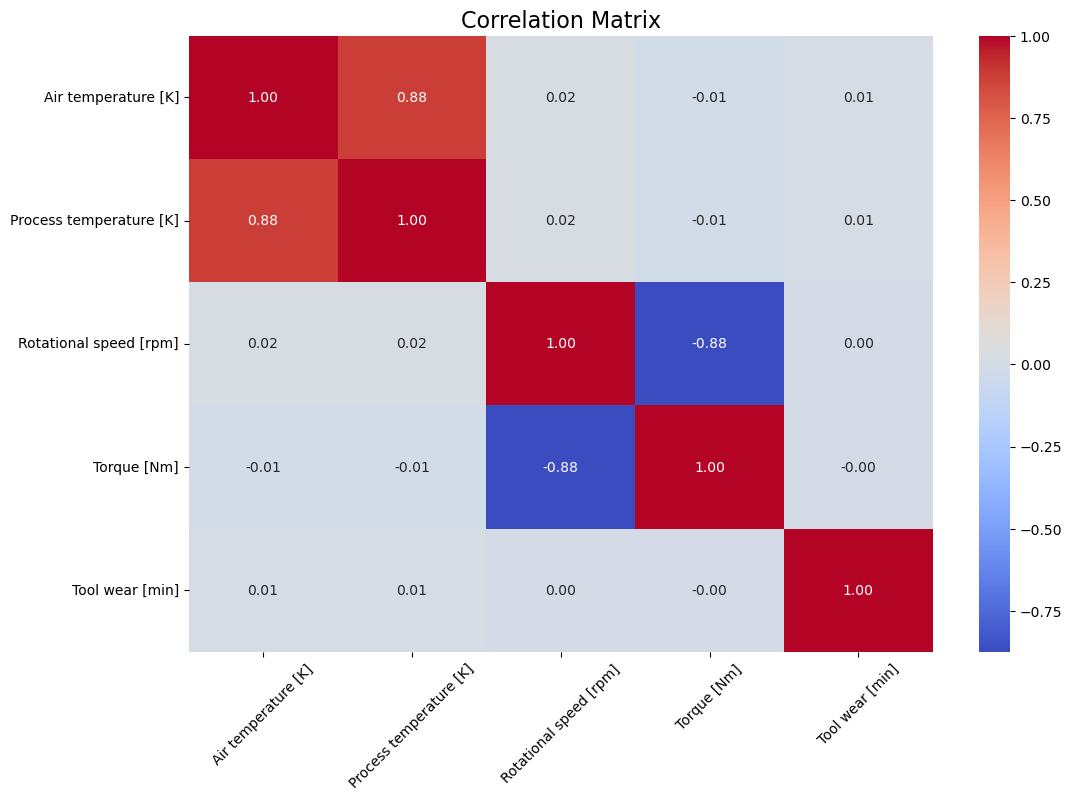

In [8]:
# Ensure the dataset contains only numerical columns for the correlation matrix
numerical_data = X.select_dtypes(include=['float64', 'int64'])

# Plot correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(numerical_data.corr(), annot=True, fmt=".2f", cmap='coolwarm', cbar=True, annot_kws={"size": 10})
plt.title("Correlation Matrix", fontsize=16)
plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=10)
plt.show()

In [9]:
numerical_data.corr()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
Air temperature [K],1.000000,0.876107,0.022670,-0.013778,0.013853
Process temperature [K],0.876107,1.000000,0.019277,-0.014061,0.013488
Rotational speed [rpm],0.022670,0.019277,1.000000,-0.875027,0.000223
Torque [Nm],-0.013778,-0.014061,-0.875027,1.000000,-0.003093
Tool wear [min],0.013853,0.013488,0.000223,-0.003093,1.000000


### Key Findings

- **Feature Selection**: The Air temperature and Process temperature variables are highly related, so one of them might be redundant for modeling. You could consider dropping one of these features to reduce multicollinearity.
- **Predictive Modeling**: The Rotational speed and Torque correlation suggests a clear inverse relationship, so they might be useful predictors for each other in a model, but the impact of temperature and tool wear might be minimal.

### 7. Model Building


Cross-Validation Results:
test_accuracy: 0.9791 ± 0.0027
test_roc_auc: 0.9984 ± 0.0002

Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1932
           1       0.48      0.75      0.58        68

    accuracy                           0.96      2000
   macro avg       0.73      0.86      0.78      2000
weighted avg       0.97      0.96      0.97      2000

Test ROC-AUC Score: 0.9690


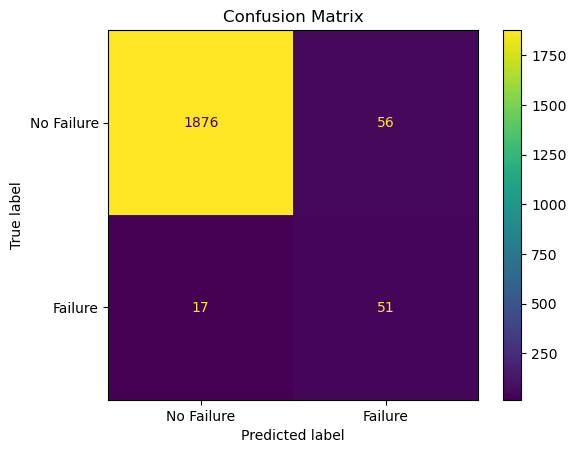

In [10]:
# Train Random Forest with Cross-Validation
rf_model = RandomForestClassifier(random_state=42)
cv_results = cross_validate(
    rf_model, X_train_balanced, y_train_balanced, cv=5, scoring=['accuracy', 'roc_auc']
)

print("\nCross-Validation Results:")
for metric, scores in cv_results.items():
    if 'test' in metric:
        print(f"{metric}: {scores.mean():.4f} ± {scores.std():.4f}")

# Fit the model on the entire training set
rf_model.fit(X_train_balanced, y_train_balanced)

# Evaluate on the test set
y_pred = rf_model.predict(X_test_scaled)
y_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

# Classification Report
print("\nTest Set Evaluation:")
print(classification_report(y_test_binary, y_pred))

# Calculate ROC-AUC
roc_auc = roc_auc_score(y_test_binary, y_pred_proba)
print(f"Test ROC-AUC Score: {roc_auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test_binary, y_pred)
ConfusionMatrixDisplay(cm, display_labels=['No Failure', 'Failure']).plot(cmap='viridis')
plt.title('Confusion Matrix')
plt.show()

#### Key Findings

- The model is highly accurate for class 0 (the negative class) but less effective for class 1 (the positive class), as seen from the significant difference in precision and recall between the two classes. The model has a high false positive rate for class 1.
- The ROC-AUC score indicates the model's strong discriminative ability, especially in distinguishing between the two classes.

### 8. Feature Importance

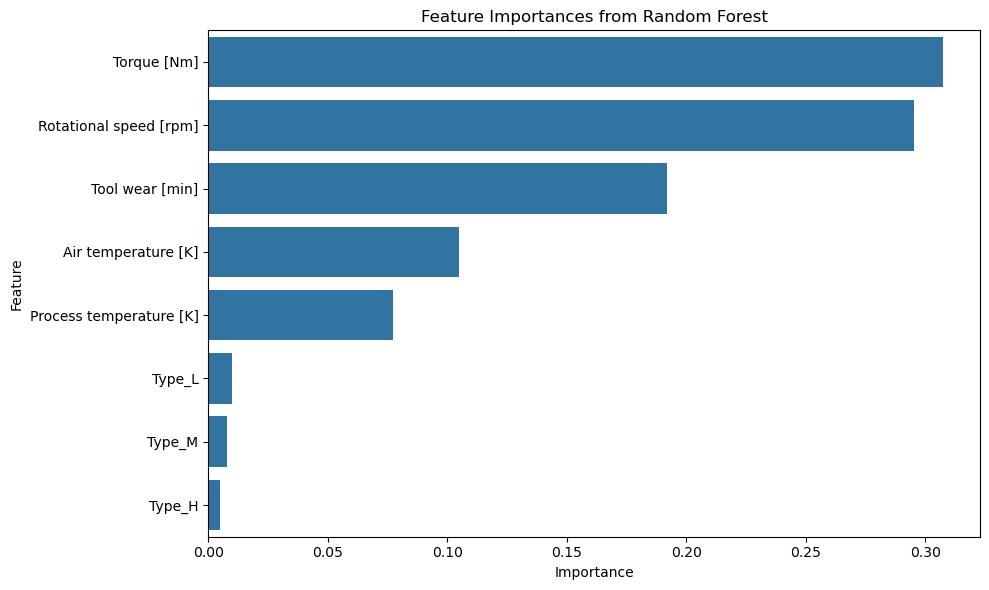

In [11]:
importances = rf_model.feature_importances_
features = X.columns

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

### 9. Hyperparameter Tuning

Perform grid search to find the optimal hyperparameters for the Random Forest model. This helps improve the model's performance.

In [12]:
# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Perform grid search
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train_balanced, y_train_balanced)

# Best hyperparameters and evaluation
print("\nBest Parameters:", grid_search.best_params_)
best_rf_model = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred_best = best_rf_model.predict(X_test_scaled)
y_pred_proba_best = best_rf_model.predict_proba(X_test_scaled)[:, 1]

print("\nBest Model Evaluation:")
print(classification_report(y_test_binary, y_pred_best))
print(f"Best Model ROC-AUC Score: {roc_auc_score(y_test_binary, y_pred_proba_best):.4f}")

Fitting 5 folds for each of 27 candidates, totalling 135 fits

Best Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 300}

Best Model Evaluation:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1932
           1       0.45      0.75      0.56        68

    accuracy                           0.96      2000
   macro avg       0.72      0.86      0.77      2000
weighted avg       0.97      0.96      0.97      2000

Best Model ROC-AUC Score: 0.9707


#### Key Findings

- The best model obtained through hyperparameter tuning performs similarly to the initial model, with very high performance for class 0 and weaker performance for class 1.
- Hyperparameter tuning did not drastically change the performance for class 1 but may have fine-tuned the model to slightly improve the ROC-AUC score.

### 10. Multi-Class Classification


Multi-Class Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.50      0.67        22
           1       0.98      1.00      0.99      1930
           2       1.00      0.50      0.67        16
           3       1.00      0.42      0.59        19
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00         9

    accuracy                           0.98      2000
   macro avg       0.66      0.40      0.49      2000
weighted avg       0.97      0.98      0.97      2000



C:\Users\milto\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\milto\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\milto\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


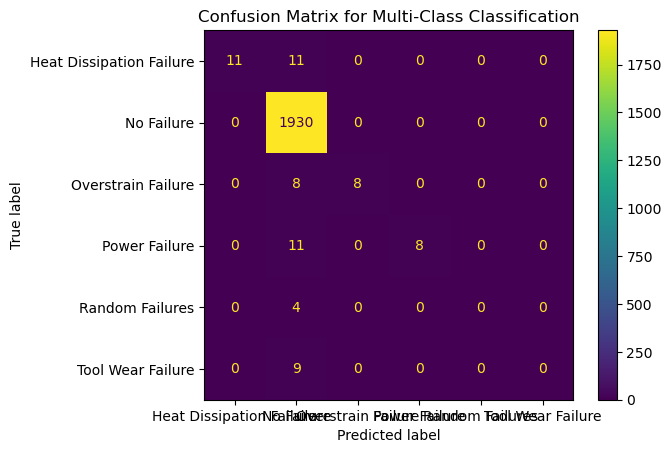

In [13]:
# Train a separate model for multi-class classification
rf_mc_model = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_mc_model.fit(X_train_mc, y_train_mc)

# Evaluate the multi-class model
y_pred_mc = rf_mc_model.predict(X_test_mc)
print("\nMulti-Class Classification Report:")
print(classification_report(y_test_mc, y_pred_mc))

# Confusion Matrix for Multi-Class Classification
cm_mc = confusion_matrix(y_test_mc, y_pred_mc)
ConfusionMatrixDisplay(cm_mc, display_labels=le.classes_).plot(cmap='viridis')
plt.title("Confusion Matrix for Multi-Class Classification")
plt.show()

#### Key Findings

- The model performs well on class 1 (which has the highest recall of 1.00), but it struggles with the other classes, especially classes 4 and 5 (which have precision, recall, and f1-scores of 0).
- The accuracy of 98% seems impressive but masks the poor performance on less frequent classes.
- The model is biased towards class 1, and better strategies might be needed to handle imbalanced data for the other classes.

## Conclusion

While the current model performs well for predicting general machinery failures, addressing class imbalance and optimizing the feature set would be essential for creating a more robust and accurate predictive maintenance system. This project lays a strong foundation for forecasting machinery failures and offers valuable insights for enhancing future maintenance strategies in manufacturing.

#### Future Work

- Addressing class imbalance is crucial to enhance the model's ability to predict failures more accurately. Techniques like SMOTE (Synthetic Minority Over-sampling Technique) or class weighting could be implemented to improve performance on the minority classes.
- Exploring ensemble models or advanced machine learning algorithms may also provide better handling of the complex relationships in the data and improve predictions for rare failure types.
- Additionally, further feature engineering could help uncover hidden patterns or refine the existing features to enhance model performance.